<a href="https://colab.research.google.com/github/dwdb/tensorflow2.0-tutorial/blob/master/time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

TRAIN_SPLIT = 300000
BUFFER_SIZE = 10000
EVALUATION_INTERVAL = 200
EPOCHS = 20
BATCH_SIZE = 256

tf.random.set_seed(13)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f40ca216ac8>],
      dtype=object)

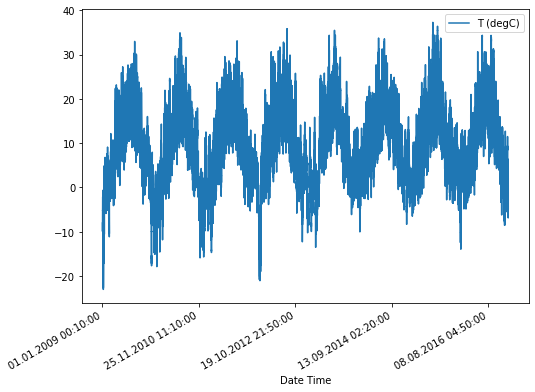

In [8]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)
df[['T (degC)', 'Date Time']].set_index('Date Time').plot(subplots=True)

In [9]:
df.shape

(420551, 15)

In [0]:
def get_dataset(data, target, history_size, target_size, step=1, single=True, training=False):
    """获取数据集"""
    n = data.shape[0]
    range_size = history_size + target_size
    x = [data[i:i + history_size:step] for i in range(n - range_size + 1)]
    if single:
        y = [data[i:i+1, target] for i in range(range_size - 1, n)]
    else:
        y = [data[i:i + target_size, target] for i in range(history_size, n - target_size + 1)]
    x = np.array(x, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    if training:
        dataset = dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
    else:
        dataset = dataset.batch(BATCH_SIZE).repeat()
    return dataset


def plot_data(history, future, predict, target_size, step, title, figure=False, show=False):
    """显示单条预测数据"""
    if figure:
        plt.figure()
    history = np.array(history).flatten()
    future = np.array(future).flatten()
    predict = np.array(predict).flatten()
    # single point
    if future.shape[0] == 1:
        delta = [0] if step == 1 else [target_size // step]
    else:
        delta = np.arange(future.shape[0]) / step
    plt.plot(range(-history.shape[0], 0), history, '.-', label='History')
    plt.plot(delta, future, 'rx', label='True Future')
    plt.plot(delta, predict, 'go', alpha=0.5, label='Model Prediction')
    plt.legend()
    plt.xlim([-history.shape[0], (max(delta) + 5) * 2])
    plt.xlabel('Time-Step')
    if show:
        plt.show()


def plot_history(history, title):
    """显示训练loss曲线"""
    plt.figure()
    epochs = range(len(history.history['loss']))
    plt.semilogy(epochs, history.history['loss'], 'b', label='Training Loss')
    plt.semilogy(epochs, history.history['val_loss'], 'r--', label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Log loss')
    plt.legend()
    plt.show()

# Simple LSTM Model

Epoch 1/20
200/200 [==============================] - 1s 7ms/step - loss: 0.4297 - val_loss: 0.0539
Epoch 2/20
200/200 [==============================] - 1s 5ms/step - loss: 0.1139 - val_loss: 0.0265
Epoch 3/20
200/200 [==============================] - 1s 5ms/step - loss: 0.0292 - val_loss: 0.0052
Epoch 4/20
200/200 [==============================] - 1s 5ms/step - loss: 0.0263 - val_loss: 0.0036
Epoch 5/20
200/200 [==============================] - 1s 5ms/step - loss: 0.0065 - val_loss: 0.0031
Epoch 6/20
200/200 [==============================] - 1s 5ms/step - loss: 0.0072 - val_loss: 0.0027
Epoch 7/20
200/200 [==============================] - 1s 5ms/step - loss: 0.0059 - val_loss: 0.0022
Epoch 8/20
200/200 [==============================] - 1s 5ms/step - loss: 0.0043 - val_loss: 0.0017
Epoch 9/20
200/200 [==============================] - 1s 5ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 10/20
200/200 [==============================] - 1s 5ms/step - loss: 0.0032 - val_loss: 0.0013

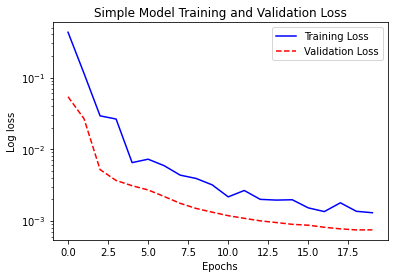

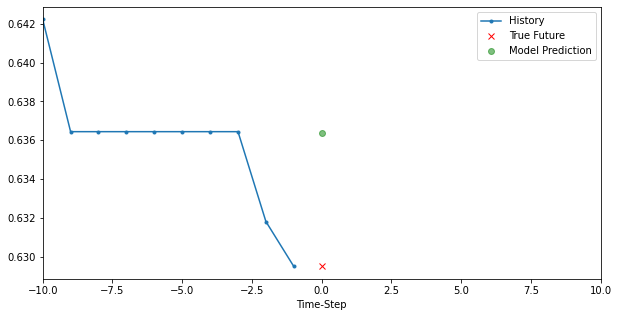

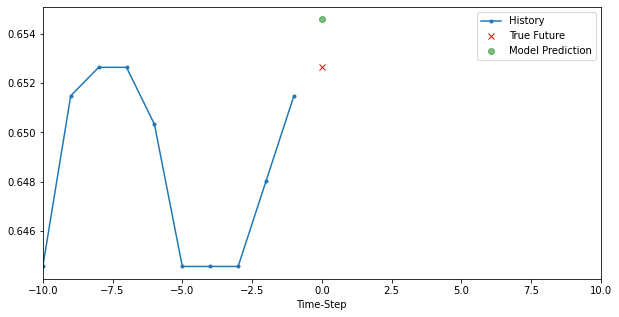

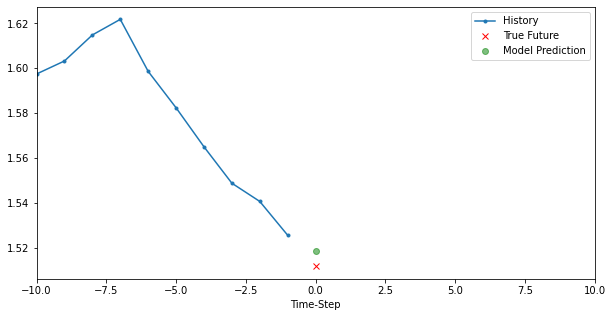

In [0]:
# split dataset
dataset = df['T (degC)'].values.reshape(-1, 1)
train_dataset, valid_dataset = dataset[:TRAIN_SPLIT], dataset[TRAIN_SPLIT:]

# standard normalization
train_mean, train_std = train_dataset.mean(axis=0), train_dataset.std(axis=0)
dataset[:] = (dataset - train_mean) / train_std

# tf.data.Dataset input pipline
target, history_size, target_size, step = 0, 10, 1, 1
train_dataset = get_dataset(train_dataset, target, history_size, target_size, training=True)
valid_dataset = get_dataset(valid_dataset, target, history_size, target_size, training=False)

# Recurrent Neural Network
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=(history_size, dataset.shape[1])),
    tf.keras.layers.Dense(1)])
model.compile(optimizer='adam', loss='mse')
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=valid_dataset,
    validation_steps=50)

# show history
plot_history(history, 'Simple Model Training and Validation Loss')

# show model prediction
# history, future, predict, target_size, step, title, figure=False, show=False    
for i, (x, y) in enumerate(valid_dataset.take(3)):
    plt.figure(figsize=(10, 5))
    x, y, p = x[0, :, target], y[0], model.predict(x)[0]
    plot_data(x, y, p, target_size, step, 'Simple LSTM model')

# Single Variate Model

Epoch 1/20
200/200 [==============================] - 2s 12ms/step - loss: 0.0970 - val_loss: 0.0546
Epoch 2/20
200/200 [==============================] - 2s 11ms/step - loss: 0.0598 - val_loss: 0.0487
Epoch 3/20
200/200 [==============================] - 2s 10ms/step - loss: 0.0565 - val_loss: 0.0546
Epoch 4/20
200/200 [==============================] - 2s 10ms/step - loss: 0.0532 - val_loss: 0.0442
Epoch 5/20
200/200 [==============================] - 2s 10ms/step - loss: 0.0441 - val_loss: 0.0463
Epoch 6/20
200/200 [==============================] - 2s 10ms/step - loss: 0.0489 - val_loss: 0.0548
Epoch 7/20
200/200 [==============================] - 2s 10ms/step - loss: 0.0499 - val_loss: 0.0509
Epoch 8/20
200/200 [==============================] - 2s 10ms/step - loss: 0.0492 - val_loss: 0.0495
Epoch 9/20
200/200 [==============================] - 2s 10ms/step - loss: 0.0502 - val_loss: 0.0480
Epoch 10/20
200/200 [==============================] - 2s 10ms/step - loss: 0.0483 - val_lo

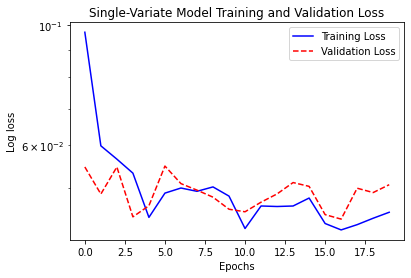

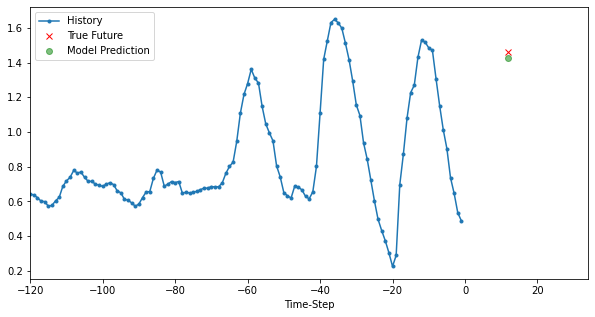

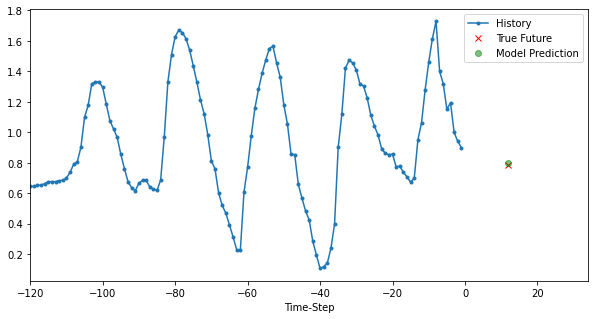

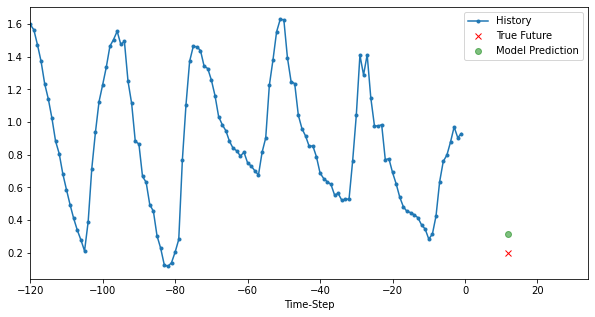

In [0]:
# split dataset
dataset = df[['p (mbar)', 'T (degC)', 'rho (g/m**3)']].values
train_dataset, valid_dataset = dataset[:TRAIN_SPLIT], dataset[TRAIN_SPLIT:]

# standard normalization
train_mean, train_std = train_dataset.mean(axis=0), train_dataset.std(axis=0)
dataset[:] = (dataset - train_mean) / train_std

# tf.data.Dataset input pipline
history_size, target, step, target_size = 720, 1, 6, 72
train_dataset = get_dataset(train_dataset, target, history_size, target_size, step, training=True)
valid_dataset = get_dataset(valid_dataset, target, history_size, target_size, step, training=False)

# creating the model in the TPUStrategy scope means we will train the model on the TPU
# with tpu_strategy.scope(): 
# Recurrent Neural Network
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)])
model.compile(optimizer='adam', loss=tf.keras.losses.Huber(delta=1.0))
history = model.fit(
    train_dataset,
    epochs= EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=valid_dataset,
    validation_steps=50)

# show history
plot_history(history, 'Single-Variate Model Training and Validation Loss')

# show single data
for i, (x, y) in enumerate(valid_dataset.take(3)):
    plt.figure(figsize=(10, 5))
    x, y, p = x[0, :, target], y[0], model.predict(x)[0]
    plot_data(x, y, p, target_size, step, 'Single-Variate LSTM model')

# Multi Variate Model

Epoch 1/20
200/200 [==============================] - 4s 21ms/step - loss: 0.2827 - val_loss: 0.1058
Epoch 2/20
200/200 [==============================] - 4s 18ms/step - loss: 0.1019 - val_loss: 0.0651
Epoch 3/20
200/200 [==============================] - 4s 18ms/step - loss: 0.0854 - val_loss: 0.0662
Epoch 4/20
200/200 [==============================] - 4s 18ms/step - loss: 0.0792 - val_loss: 0.0597
Epoch 5/20
200/200 [==============================] - 4s 18ms/step - loss: 0.0650 - val_loss: 0.0618
Epoch 6/20
200/200 [==============================] - 4s 18ms/step - loss: 0.0708 - val_loss: 0.0678
Epoch 7/20
200/200 [==============================] - 4s 18ms/step - loss: 0.0684 - val_loss: 0.0701
Epoch 8/20
200/200 [==============================] - 3s 17ms/step - loss: 0.0685 - val_loss: 0.0586
Epoch 9/20
200/200 [==============================] - 3s 17ms/step - loss: 0.0686 - val_loss: 0.0584
Epoch 10/20
200/200 [==============================] - 4s 18ms/step - loss: 0.0636 - val_lo

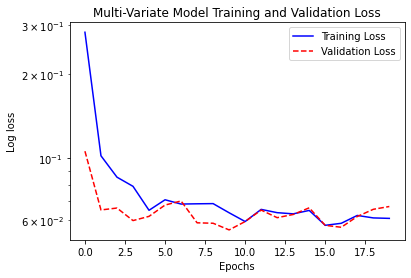

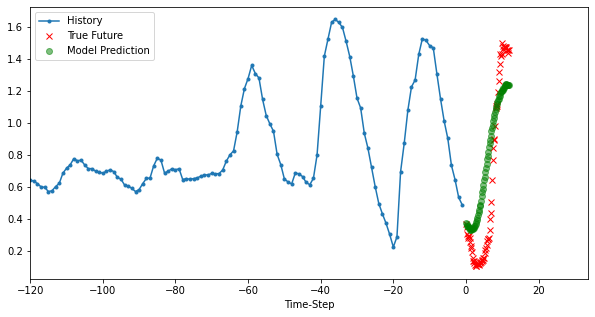

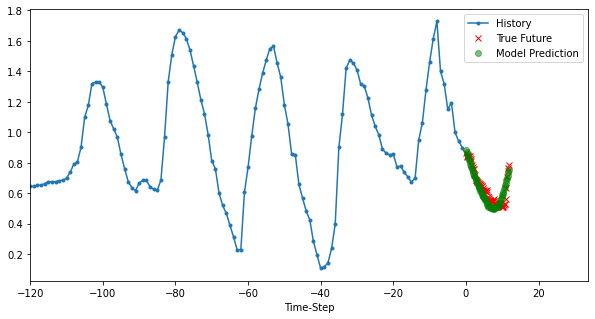

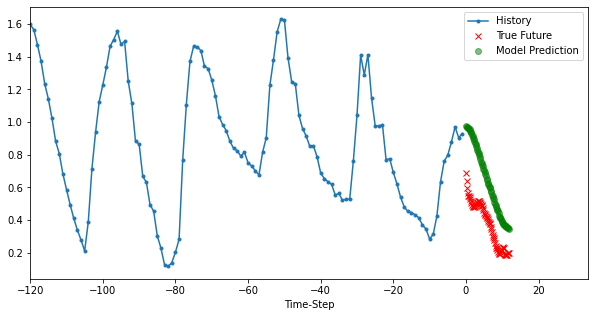

In [0]:
# split dataset
dataset = df[['p (mbar)', 'T (degC)', 'rho (g/m**3)']].values
train_dataset, valid_dataset = dataset[:TRAIN_SPLIT], dataset[TRAIN_SPLIT:]

# standard normalization
train_mean, train_std = train_dataset.mean(axis=0), train_dataset.std(axis=0)
dataset[:] = (dataset - train_mean) / train_std

# tf.data.Dataset input pipline
history_size, target, step, target_size = 720, 1, 6, 72
train_dataset = get_dataset(train_dataset, target, history_size, target_size, step, single=False, training=True)
valid_dataset = get_dataset(valid_dataset, target, history_size, target_size, step, single=False, training=False)

# creating the model in the TPUStrategy scope means we will train the model on the TPU
# with tpu_strategy.scope(): 
# Recurrent Neural Network
model = tf.keras.models.Sequential([                         
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, activation='tanh'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(target_size)])
model.compile(optimizer='adam', loss='mse')
history = model.fit(
    train_dataset,
    epochs= EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=valid_dataset,
    validation_steps=50)

# show history
plot_history(history, 'Multi-Variate Model Training and Validation Loss')

# show single data
for i, (x, y) in enumerate(valid_dataset.take(3)):
    plt.figure(figsize=(10, 5))
    x, y, p = x[0, :, target], y[0], model.predict(x)[0]
    plot_data(x, y, p, target_size, step, 'Multi-Variate LSTM model')
